Python module to perform machine learning on the ST data and to visualize the results. This script was used on the slide 34C only. The segmentation was made with Stardist.

# Import

In [13]:
import anndata as ad
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns
from seaborn import objects as so
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Input

An AnnData object containing a dataset where each row is a tile and each column is a feature (extracted from the image by segmentation). The AnnData object contains also a obs where you can find pathologist's annotation and the path to each tile. Moreover, you can find the segmentation data processed with a PCA in the obsm part of the AnnData object.

In [7]:
adata = ad.read_h5ad('/disk2/user/cormey/outputs/Segmentation_objects/034_RJ.C1.h5ad')

# Output

Some graphs to visualize the performance of the machine learning and the quality of the features extracted by segmentation

# Visualize the AnnData object

In [9]:
print(adata.var_names)

Index(['segmented_label', 'segmented_area_mean', 'segmented_area_std',
       'segmented_bbox_area_mean', 'segmented_bbox_area_std',
       'segmented_convex_area_mean', 'segmented_convex_area_std',
       'segmented_eccentricity_mean', 'segmented_eccentricity_std',
       'segmented_equivalent_diameter_mean',
       'segmented_equivalent_diameter_std', 'segmented_euler_number_mean',
       'segmented_euler_number_std', 'segmented_extent_mean',
       'segmented_extent_std', 'segmented_feret_diameter_max_mean',
       'segmented_feret_diameter_max_std', 'segmented_major_axis_length_mean',
       'segmented_major_axis_length_std', 'segmented_minor_axis_length_mean',
       'segmented_minor_axis_length_std', 'segmented_orientation_mean',
       'segmented_orientation_std', 'segmented_perimeter_mean',
       'segmented_perimeter_std', 'segmented_solidity_mean',
       'segmented_solidity_std'],
      dtype='object')


In [8]:
adata.obs.head()

,path,annotation
0,/disk2/user/cormey/outputs/Tilted_images/034_R...,Mixed
1,/disk2/user/cormey/outputs/Tilted_images/034_R...,Mixed
2,/disk2/user/cormey/outputs/Tilted_images/034_R...,Mixed
3,/disk2/user/cormey/outputs/Tilted_images/034_R...,Mixed
4,/disk2/user/cormey/outputs/Tilted_images/034_R...,Mixed


In [10]:
print(adata.X[:10, :20])

[[8.00000000e+00 1.51412500e+03 1.23305834e+03 1.97425000e+03
  1.61632057e+03 1.54850000e+03 1.24649258e+03 6.61739614e-01
  1.28501719e-01 4.01106723e+01 1.78599494e+01 1.00000000e+00
  0.00000000e+00 7.58142058e-01 5.66055963e-02 4.90330428e+01
  2.10596941e+01 4.74397455e+01 2.07645506e+01 3.47138376e+01]
 [8.00000000e+00 1.46775000e+03 5.68495328e+02 2.04537500e+03
  9.45076444e+02 1.50337500e+03 5.81485799e+02 7.12234474e-01
  1.27466106e-01 4.25146550e+01 7.82952424e+00 1.00000000e+00
  0.00000000e+00 7.42337450e-01 6.28819978e-02 5.36950216e+01
  1.23478605e+01 5.27505362e+01 1.29643611e+01 3.47533230e+01]
 [2.80000000e+01 7.84750000e+02 2.21173272e+02 1.09214286e+03
  3.69837775e+02 8.19071429e+02 2.33970683e+02 7.35280953e-01
  1.50280798e-01 3.12822961e+01 4.53791650e+00 1.00000000e+00
  0.00000000e+00 7.33058130e-01 6.91281794e-02 4.12841246e+01
  8.91905967e+00 4.05634242e+01 9.32881418e+00 2.48272020e+01]
 [6.00000000e+00 7.00333333e+02 2.95984609e+02 9.35333333e+02
  4.0

# Visualize the PCA

In [17]:
X=adata.X

# Create an PCA object with the number of wanted principal componants
pca = PCA(n_components=5)  # 5 PC

# Perform the PCA on the matrix X
reduced_features = pca.fit_transform(X)

# Check the results
print("Shape of reduced features:", reduced_features.shape)


Shape of reduced features: (2061, 5)


In [18]:
#See how much each components explain the total variance of the dataset

explained_variance_ratio = pca.explained_variance_ratio_

# Display results
for i, variance in enumerate(explained_variance_ratio):
    print(f"Principal component {i+1}: {variance:.2%} of the variance")

Principal component 1: 76.69% of the variance
Principal component 2: 22.45% of the variance
Principal component 3: 0.58% of the variance
Principal component 4: 0.16% of the variance
Principal component 5: 0.06% of the variance


In [19]:
#Visualize which variable are influencing the PC

# Stock the PC in a variable
loadings = pca.components_

# Convert the PC in a dataset to have a better readability
pc_loadings = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(loadings.shape[0])], index=adata.var_names)
print(pc_loadings)

                                             PC1       PC2       PC3  \
segmented_label                    -8.416752e-03 -0.009451 -0.052828   
segmented_area_mean                 4.345797e-01 -0.259607 -0.434773   
segmented_area_std                  2.530203e-01  0.432470 -0.369861   
segmented_bbox_area_mean            6.013886e-01 -0.324950  0.525998   
segmented_bbox_area_std             3.401474e-01  0.601930  0.477500   
segmented_convex_area_mean          4.507810e-01 -0.268952 -0.261422   
segmented_convex_area_std           2.558888e-01  0.451750 -0.310755   
segmented_eccentricity_mean        -9.716054e-08  0.000026  0.000480   
segmented_eccentricity_std         -4.921596e-06  0.000016 -0.000082   
segmented_equivalent_diameter_mean  7.159109e-03 -0.005607 -0.006310   
segmented_equivalent_diameter_std   2.626652e-03  0.006371 -0.002388   
segmented_euler_number_mean         3.586857e-06 -0.000006  0.000095   
segmented_euler_number_std          4.619604e-06 -0.000007  0.00

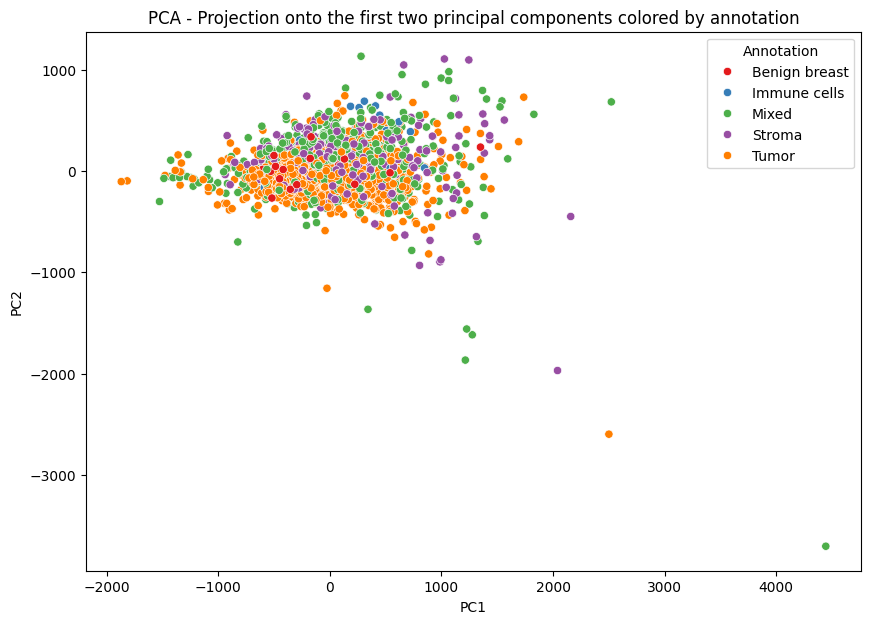

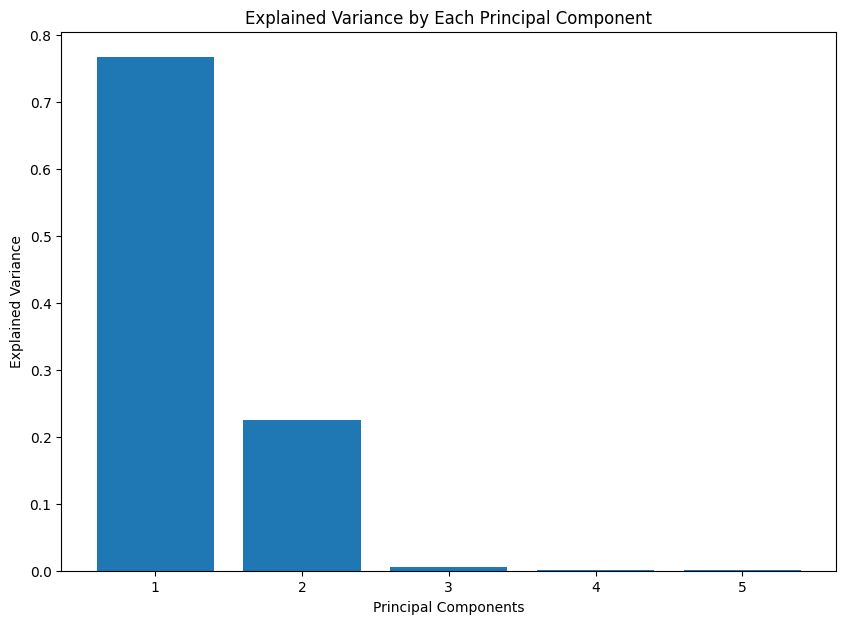

In [20]:
# Extract the first two principal components
pc1 = adata.obsm['X_pca'][:, 0]
pc2 = adata.obsm['X_pca'][:, 1]

# Stock the annotation in a variable
labels = adata.obs['annotation']

# Scatter plot of the first two principal components
plt.figure(figsize=(10, 7))
sns.scatterplot(x=pc1, y=pc2, hue=labels, palette='Set1')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA - Projection onto the first two principal components colored by annotation')
plt.legend(title='Annotation')
plt.show()

# Explained variance by each principal component
explained_variance = pca.explained_variance_ratio_

# Create the explained variance plot
plt.figure(figsize=(10, 7))
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Each Principal Component')
plt.show()

# Perform the Machine Learning

In [21]:
##Perform a machine learning algorithm on the segmented dataset

labels = adata.obs["annotation"]  # Extraction of pathologist's annotation

# Extract segmentation features and annotation
X = adata.X
y = labels

# Split data in a train dataset and a test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the classification model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test dataset
y_pred = model.predict(X_test)

# Display the classification report
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

Benign breast       0.00      0.00      0.00         3
 Immune cells       0.00      0.00      0.00        15
        Mixed       0.48      0.55      0.51       177
       Stroma       0.17      0.08      0.11        76
        Tumor       0.77      0.83      0.80       348

     accuracy                           0.63       619
    macro avg       0.28      0.29      0.28       619
 weighted avg       0.59      0.63      0.61       619



/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [22]:
##Perform a machine learning algorithm on the segmented dataset (PCA version)

labels = adata.obs["annotation"]  # Extraction of pathologist's annotation

# Extract segmentation features and annotation
X = adata.obsm['X_pca']
y = labels

# Split data in a train dataset and a test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the classification model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test dataset
y_pred = model.predict(X_test)

# Display the classification report
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

Benign breast       0.00      0.00      0.00         3
 Immune cells       0.75      0.20      0.32        15
        Mixed       0.45      0.55      0.49       177
       Stroma       0.29      0.12      0.17        76
        Tumor       0.76      0.79      0.77       348

     accuracy                           0.62       619
    macro avg       0.45      0.33      0.35       619
 weighted avg       0.61      0.62      0.61       619



/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f